In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import *
import h5py
import scipy.stats as sts

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.syndat.MMDA import generate
from ATARI.theory.xs import SLBW
from ATARI.theory.scattering_params import FofE_recursive
from ATARI.theory.scattering_params import gstat
from ATARI.utils.datacontainer import DataContainer
from ATARI.utils.atario import fill_resonance_ladder

from numpy.linalg import inv
from scipy.linalg import block_diag

from scipy.optimize import lsq_linear
from qpsolvers import solve_qp

import functions as fn 


In [2]:
# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
%matplotlib widget

In [12]:

def gn2G(row):
    S, P, phi, k = FofE_recursive([row.E], Ta_pair.ac, Ta_pair.M, Ta_pair.m, row.lwave)
    Gnx = 2*np.sum(P)*row.gnx2
    return Gnx.item()

def G2gn(row):
    S, P, phi, k = FofE_recursive([row.E], Ta_pair.ac, Ta_pair.M, Ta_pair.m, row.lwave)
    gnx2 = row.Gnx/2/np.sum(P)
    return gnx2.item()


#%%
ac = 0.81271  # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider


Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={})



spin_groups = [ (3.0,1,0)] # , (4.0,1,[0]) ]
average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':8.79, '4.0':4.99},
                                    'Gg'    :   {'3.0':64.0, '4.0':64.0},
                                    'gn2'    :   {'3.0':46.4, '4.0':35.5}  })


E_min_max = [550, 600]
energy_grid = E_min_max

input_options = {'Add Noise': True,
                'Calculate Covariance': True,
                'Compression Points':[],
                'Grouping Factors':None}

experiment_parameters = {'bw': {'val':0.0256,    'unc'   :   0}}

# initialize experimental setup
exp = Experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)


resonance_ladder = Ta_pair.sample_resonance_ladder(E_min_max, spin_groups, average_parameters, False)
# resonance_ladder = pd.DataFrame({'E':[570], 'J':[3.0], 'chs':[1.0], 'lwave':[0.0], 'J_ID':[1.0], 'gnx2':[100], 'Gg':[750]})
Gnx = resonance_ladder.apply(lambda row: gn2G(row), axis=1)
resonance_ladder['Gt'] = Gnx + resonance_ladder['Gg']

print(resonance_ladder)

true, _, _ = SLBW(exp.energy_domain, Ta_pair, resonance_ladder)
df_true = pd.DataFrame({'E':exp.energy_domain, 'theo_trans':np.exp(-exp.redpar.val.n*true)})

# resonance_ladder
exp.run(df_true)

# figure()
# errorbar(exp.trans.E, exp.trans.exp_trans, yerr=exp.trans.exp_trans_unc, fmt='.')
# plot(exp.theo.E, exp.theo.theo_trans)
# axhline(0)

            E         Gg       gnx2    J  chs  lwave  J_ID         Gt
0  552.690094  61.334492   8.329729  3.0  1.0    0.0   1.0  62.029894
1  572.864432  64.477611   1.737910  3.0  1.0    0.0   1.0  64.625323
2  581.776221  61.502104   7.378223  3.0  1.0    0.0   1.0  62.134071
3  590.032482  63.363393  24.534938  3.0  1.0    0.0   1.0  65.479741


In [13]:
data = DataContainer()
data.add_theoretical(Ta_pair, resonance_ladder)
data.add_experimental(exp)

data.fill()
# figure()
# plot(data.pw_fine.E, data.pw_fine.theo_xs)
# errorbar(data.pw_exp.E, data.pw_exp.exp_xs, yerr=data.pw_exp.exp_xs_unc, fmt='.')

In [14]:
average_parameters.loc[:,['Gn']] = average_parameters['gn2']/12.5
Elam_features, Gtot_features = fn.get_parameter_grid(energy_grid, average_parameters, '3.0', 1e-1, 1e-2)
Gtot_features = np.round(np.array(resonance_ladder.Gt),1)*1e-3
# Gtot_features = [0.755, 0.758, 0.760]
# print(Elam_features, Gtot_features)
# print(Gtot_features)
print(f'Feature bank size: {len(Elam_features)*len(Gtot_features)}')

Resonance_Matrix, potential_scattering, feature_pairs = fn.get_resonance_feature_bank(data.pw_exp.E, data.particle_pair, Elam_features, Gtot_features)
nfeatures = np.shape(Resonance_Matrix)[1]

CovXS = data.CovXS
exp_xs = data.pw_exp.exp_xs

Feature bank size: 2004


In [15]:
# setup
b = (np.array(exp_xs)-potential_scattering).flatten()
A = Resonance_Matrix
lb, ub = fn.get_bound_arrays(nfeatures, 0, 1)

### Cast into linear least squares and solve
# Lxs = np.linalg.cholesky(inv(CovXS))
# bp = Lxs.T @ b
# Ap = Lxs.T @ A
# res_ls = lsq_linear(Ap, bp, bounds=(lb,ub), 
#                             lsmr_tol='auto', 
#                             lsq_solver='lsmr',
#                             max_iter = 500, 
#                             verbose=1)

### Cast into quadratic program and solve
P =  A.T @ inv(CovXS) @ A #*0
q = - A.T @ inv(CovXS) @ b
qp_res = solve_qp(P, q, G=None, h=None, A=None, b=None, lb=lb, ub=ub, 
                                                        solver="cvxopt",
                                                        verbose=False,
                                                        abstol=1e-10,
                                                        reltol=1e-10,
                                                        feastol= 1e-8,
                                                        maxiters = 500
                                                                            )
# [print(each) for each in qp_res]

In [16]:

# ### solve linear program
from scipy.optimize import linprog

# # lp_res = linprog(q, A_ub=None, b_ub=None, bounds=np.array([lb, ub]).T)
# lp_res = linprog(q, A_ub=np.atleast_2d(G), b_ub=h, bounds=np.array([lb, ub]).T)
# [print(each) for each in lp_res.x]
# print(Elam_features)
# print(res_ls.x)
# print(qp_res)

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


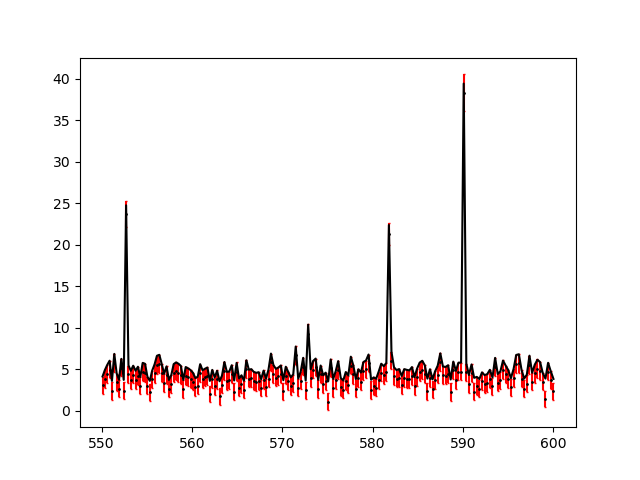

In [17]:
# print(Elam_features)
# print(res_ls.x)
# print(res_qp.x)
# print(qp_x)


figure()
errorbar(data.pw_exp.E, data.pw_exp.exp_xs, yerr=np.sqrt(np.diag(CovXS)), fmt='.', ecolor='r', color='k', capsize=1, ms=2)
# plot(E, Resonance_Matrix@res_ls.x+potential_scattering.flatten(), lw=5, color='cornflowerblue')
plot(data.pw_exp.E, Resonance_Matrix@qp_res+potential_scattering.flatten(), color='k')
# plot(data.pw_exp.E, Resonance_Matrix@lp_res.x+potential_scattering.flatten(), color='b')

# figure()
# bins = hist(np.log10(qp_res), bins=100)

### Constrain the solution without reducing feature map

In [18]:
from ATARI.utils.stats import chi2_val

print(sum(qp_res))

basename = '/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/SLBW_noexp/figures/'
# basename_saves = '/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/SLBW_noexp/lasso'
case = 'test'


0.4564641544246005


In [19]:
x_constrained = []
lp_constrained = []

for fac in np.linspace(0,1,20):
    G = np.ones(len(qp_res))
    h = np.array([[sum(qp_res)*fac]])

    qp_x_c = solve_qp(P, q, G=G, h=h, A=None, b=None, lb=lb, ub=ub, solver="cvxopt")
    lp_res = linprog(q, A_ub=np.atleast_2d(G), b_ub=h, bounds=np.array([lb, ub]).T)

    qp_x_c = solve_qp(P, q, G=G, h=h, A=None, b=None, lb=lb, ub=ub, 
                                                        solver="cvxopt")#,
                                                        # verbose=False,
                                                        # abstol=1e-10,
                                                        # reltol=1e-10,
                                                        # feastol= 1e-8,
                                                        # maxiters = 500)
    if qp_x_c is None:
        qp_x_c = solve_qp(P, q, G=G, h=h, A=None, b=None, lb=lb, ub=ub, 
                                                        solver="cvxopt")#,
                                                        # verbose=False,
                                                        # abstol=1e-9,
                                                        # reltol=1e-9,
                                                        # feastol= 1e-7,
                                                        # maxiters = 500)
        
    
    lp_constrained.append(lp_res.x)
    x_constrained.append(qp_x_c)


ws_vs_factor = np.array(x_constrained)
ws_vs_factor_lp = np.array(lp_constrained)

# np.save(f'wvfactor_{case}.npy',ws_vs_factor)
# np.save(f'wvfactor_{case}_lp.npy',ws_vs_factor_lp)
# np.save( 'factors.npy',factors)

In [20]:
from scipy.integrate import trapezoid
from ATARI.utils.misc import fine_egrid


def get_resonance_ladder_from_matrix(weights, Elam_features, Gtot_features, threshold):
    feature_indices = np.argwhere(weights>threshold).flatten()
    resonances = []
    for ifeature in feature_indices:
        Efeature_index, Gfeature_index = divmod(ifeature, len(Gtot_features))
        Elam = Elam_features[Efeature_index]
        Gt = Gtot_features[Gfeature_index]*1e3
        w = weights[ifeature]
        Gnx = Gt*w
        Gg = Gt-Gnx
        resonances.append([Elam, Gt, Gnx, Gg, w])
    resonance_ladder = pd.DataFrame(resonances, columns=['E', 'Gt', 'Gnx', 'Gg', 'w'])
    return resonance_ladder

def calculate_integral_FoMs(weights, Elam_features, Gtot_features, threshold, datacon):
    est_resonance_ladder = get_resonance_ladder_from_matrix(weights, Elam_features, Gtot_features, threshold)
    est_resonance_ladder = fill_resonance_ladder(est_resonance_ladder, Ta_pair, J=3.0, chs=1.0, lwave=0.0, J_ID=1.0)

    xs = Resonance_Matrix@weights+potential_scattering.flatten()
    trans = np.exp(-exp.redpar.val.n*xs)

    fineE = fine_egrid(datacon.pw_exp.E, 1e2)
    est_xs_tot, _, _ = SLBW(fineE, datacon.particle_pair, est_resonance_ladder)
    theo_xs_tot, _, _ = SLBW(fineE, datacon.particle_pair, datacon.theo_resonance_ladder)
    MSE = trapezoid((est_xs_tot-theo_xs_tot)**2, fineE)
    bias = est_xs_tot-theo_xs_tot

    return MSE, bias

In [21]:

# ws_vs_factor =  np.load(f'wvfactor_{case}.npy')
# ws_vs_factor_lp =  np.load(f'wvfactor_{case}_lp.npy')
factors = np.repeat(np.atleast_2d(np.linspace(0,1,50)), len(ws_vs_factor.T), axis=0)  

# # factors = np.load('factors.npy')
# factors = np.repeat(np.atleast_2d(np.linspace(0,1,50)), len(ws_vs_factor.T), axis=0)  


In [22]:

chi2 = []
chi2_trans = []
MSE_list = []
mean_bias = []
std_bias = []

MSE_list_lp = []
mean_bias_lp = []
std_bias_lp = []

inonzero = []
nonzero_w = []; threshold = 1e-10
izero_init = np.argwhere(qp_res<threshold).flatten()
num_revived = []

for ifac, fac in enumerate(np.linspace(0,1,50)):

    ### make hist for gif
    # figure()
    # bins = hist(np.log10(ws_vs_factor[ifac]), bins=100)
    # title(f'Factor: {fac}')
    # savefig(os.path.join(basename,'constrain_w_giffigs', f'histwf_{case}_{ifac}.png'))
    # close()

    current_w = ws_vs_factor[ifac]
    current_w_lp = ws_vs_factor_lp[ifac]

    ### calculate chi2
    xs = Resonance_Matrix@current_w+potential_scattering.flatten()
    xs_lp = Resonance_Matrix@current_w_lp+potential_scattering.flatten()
    trans = np.exp(-data.n*xs)

    chi2_trans.append( chi2_val(trans, data.pw_exp.exp_trans, data.CovT).flatten() )
    chi2.append(chi2_val(xs, data.pw_exp.exp_xs, CovXS).flatten())

    ### calculate integral values
    MSE, bias = calculate_integral_FoMs(current_w, Elam_features, Gtot_features, 1e-10, data)

    MSE_list.append(MSE)
    mean_bias.append(np.mean(abs(bias)))
    std_bias.append(np.std(abs(bias)))

    ### Calculate integral values for LP
    MSE_lp, bias_lp = calculate_integral_FoMs(current_w_lp, Elam_features, Gtot_features, 1e-10, data)
    MSE_list_lp.append(MSE_lp)
    mean_bias_lp.append(np.mean(abs(bias_lp)))
    std_bias_lp.append(np.std(abs(bias_lp)))

    ### count things
    izero_thisf = np.argwhere(current_w<threshold)
    nonzero_thisf = np.argwhere(current_w>threshold).flatten()
    true_if_revived = [init not in izero_thisf for init in izero_init]

    inonzero.append(len(nonzero_thisf))
    nonzero_w.append(current_w[nonzero_thisf])
    num_revived.append(np.count_nonzero(true_if_revived))

    ### make xs plot for gif
    # figure()
    # errorbar(data.pw_exp.E, data.pw_exp.exp_xs, yerr=np.sqrt(np.diag(data.CovXS)), fmt='.', ecolor='r', color='k', capsize=1, ms=2)
    # plot(data.pw_exp.E, xs, color='g', label='QuadProg')
    # plot(data.pw_exp.E, xs_lp, color='b', label='LinProg')
    # legend()
    # title(f'Factor: {fac}')
    # savefig(os.path.join(basename,'constrain_w_giffigs', f'xs_{case}_{ifac}.png'))
    # close()
    # fig, axes = subplots(1,2, figsize=(10,5))
    # axes[0].errorbar(exp.trans.E, exp.trans.exp_xs, yerr=np.sqrt(np.diag(CovXS)), fmt='.', ecolor='r', color='k', capsize=1, ms=2)
    # axes[0].plot(E, xs, color='g')
    # axes[1].errorbar(exp.trans.E, exp.trans.exp_trans, yerr=np.sqrt(np.diag(CovT)), fmt='.', ecolor='r', color='k', capsize=1, ms=2)
    # axes[1].plot(E, trans, color='g')
    # title(f'Factor: {fac}')
    # savefig(os.path.join(basename,'constrain_w_giffigs', f'xstrans_{case}_{ifac}.png'))
    # close()

    ### make scatterplot of wlp vs wqp
    # figure()
    # scatter(current_w, current_w_lp)
    # xlabel('QP'); ylabel('LP')
    # title(f'Factor: {fac}')
    # savefig(os.path.join(basename,'constrain_w_giffigs', f'wQPvswLP{ifac}.png'))
    # close()


chi2 = np.array(chi2)
chi2_trans = np.array(chi2_trans)
inonzero = np.array(inonzero)
MSE_list = np.array(MSE_list)
mean_bias = np.array(mean_bias)
std_bias = np.array(std_bias)

MSE_list_lp = np.array(MSE_list_lp)
mean_bias_lp = np.array(mean_bias_lp)
std_bias_lp = np.array(std_bias_lp)
### Spaghetti plot of weights vs factor
# figure(figsize=(10,5))
# out = plot(factors.T, np.log10(ws_vs_factor))
# ylabel('Log10(w)')
# xlabel('Factor')


IndexError: index 20 is out of bounds for axis 0 with size 20

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


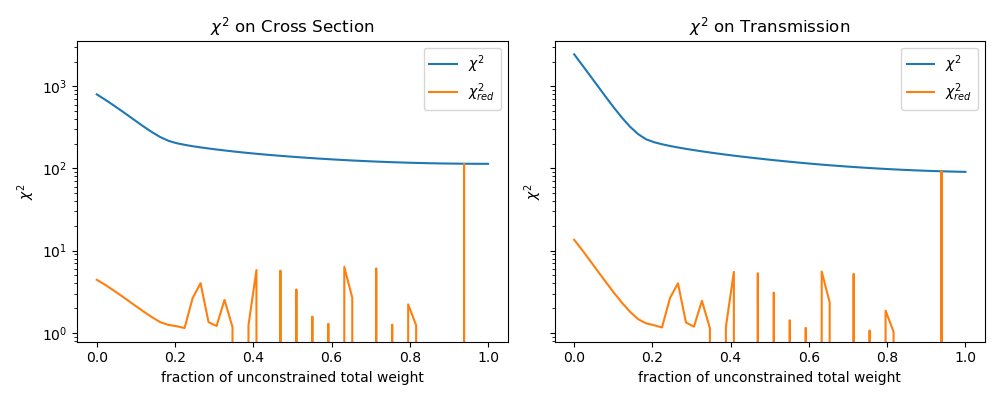

In [ ]:
fig, axes = subplots(1,2, figsize=(10,4), sharex=True, sharey=True)

axes[0].plot(np.linspace(0,1,50), chi2.flatten(), label=r'$\chi^2$')
axes[0].plot(np.linspace(0,1,50), chi2.flatten()/(len(data.pw_exp.E)-inonzero), label=r'$\chi^2_{red}$')
axes[1].plot(np.linspace(0,1,50), chi2_trans.flatten(), label=r'$\chi^2$')
axes[1].plot(np.linspace(0,1,50), chi2_trans.flatten()/(len(data.pw_exp.E)-inonzero), label=r'$\chi^2_{red}$')

# axes[2].plot(np.linspace(0,1,50), chi2.flatten()/(len(E)-nonzero*3), label=r'$\chi^2_{\sigma}$')
# axes[2].plot(np.linspace(0,1,50), chi2_trans.flatten()/(len(E)-nonzero*3), label=r'$\chi^2_{trans}$')


# for ax in axes[0:2]:
#     ax.set_yscale('log')
#     # ax.set_xscale('log')
for ax in axes:
    ax.set_yscale('log')
    ax.set_xlabel('fraction of unconstrained total weight')
    ax.set_ylabel(r'$\chi^2$')
    ax.legend()

# axes[0].set_ylabel(r'$\chi^2$')
axes[0].set_title(r'$\chi^2$ on Cross Section')
axes[1].set_title(r'$\chi^2$ on Transmission')
# axes[2].set_title(r'$\chi^2_{red}$ with dof=#respar')
fig.tight_layout()

In [94]:
# data.pw_exp.E[np.argwhere(min(chi2_trans.flatten()))]
# np.argwhere(min(chi2_trans.flatten()))

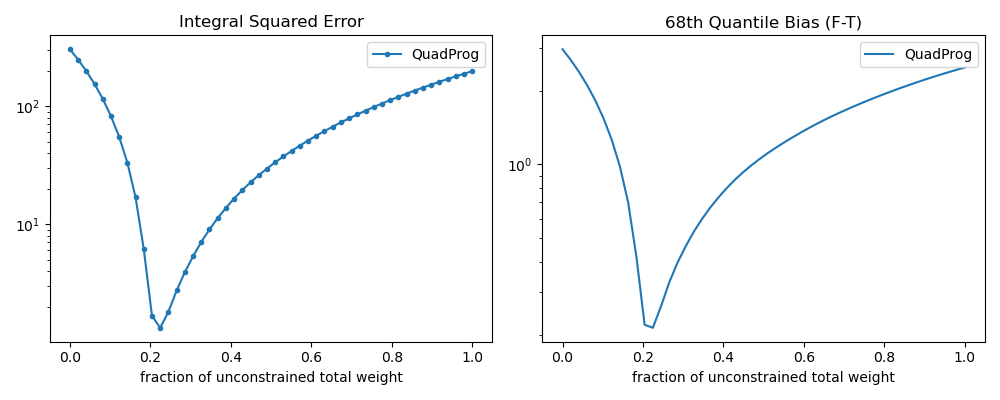

In [95]:
fig, axes = subplots(1,2, figsize=(10,4), sharex=True)

axes[0].plot(np.linspace(0,1,50), MSE_list.flatten(), label='QuadProg',marker='.')
axes[1].plot(np.linspace(0,1,50), mean_bias.flatten()+std_bias.flatten(), label='QuadProg')

# axes[0].plot(np.linspace(0,1,50), MSE_list_lp.flatten(), label='LinProg',marker='.')
# axes[1].plot(np.linspace(0,1,50), mean_bias_lp.flatten()+std_bias.flatten(), label='LinProg')
# axes[1].axvline(data.pw_exp.E[np.argwhere(min(chi2_trans.flatten()))], label=r'$\chi^2$')

for ax in axes:
    ax.legend()
    ax.set_yscale('log')
    ax.set_xlabel('fraction of unconstrained total weight')

axes[0].set_title('Integral Squared Error')
axes[1].set_title('68th Quantile Bias (F-T)')
fig.tight_layout()